In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("../data/ais_train.csv", sep="|")
ports = pd.read_csv("../data/ports.csv", sep="|").rename(
    {
        "portId": "closest_port",
        "latitude": "latitude_right",
        "longitude": "longitude_right",
    },
    axis=1,
)
ports.head()

,closest_port,name,portLocation,longitude_right,latitude_right,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


In [3]:
ports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   closest_port     1329 non-null   object 
 1   name             1329 non-null   object 
 2   portLocation     1329 non-null   object 
 3   longitude_right  1329 non-null   float64
 4   latitude_right   1329 non-null   float64
 5   UN_LOCODE        1329 non-null   object 
 6   countryName      1329 non-null   object 
 7   ISO              1329 non-null   object 
dtypes: float64(2), object(6)
memory usage: 83.2+ KB


In [4]:
MAP_LAND_PATH = "../data/land_and_ocean/ne_10m_land.zip"  # Path to the land zip file
MAP_OCEAN_PATH = "../data/land_and_ocean/ne_10m_ocean.zip"  # Path to the ocean zip file
land_world = gpd.read_file(MAP_LAND_PATH)
ocean_world = gpd.read_file(MAP_OCEAN_PATH)

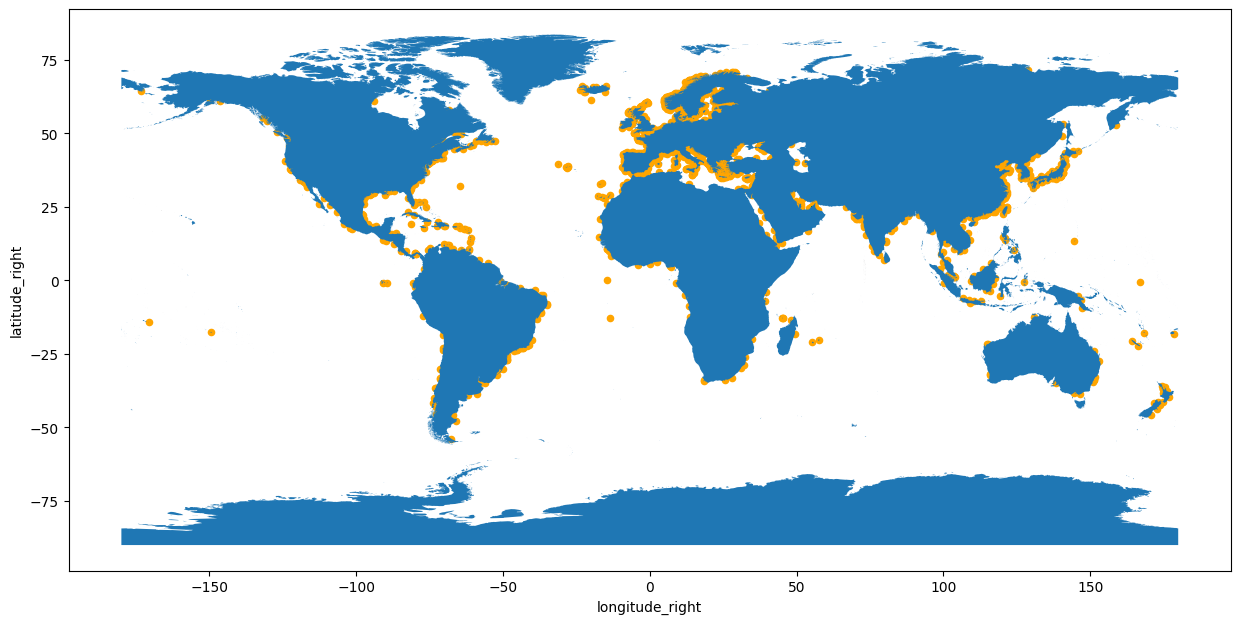

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ports.plot.scatter(x="longitude_right", y="latitude_right", ax=ax, c="orange")
land_world.plot(ax=ax)
plt.show()

In [6]:
def df_to_gdf(
    df: pd.DataFrame, longitude_col="longitude", latitude_col="latitude"
) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[longitude_col], df[latitude_col]),
        crs="EPSG:4326",
    )

In [7]:
orig_cols = train_df.columns.to_list()
distance_col = "dist_to_port"

ports_gdf = df_to_gdf(
    ports, longitude_col="longitude_right", latitude_col="latitude_right"
).to_crs(epsg="3857")

train_gdf = df_to_gdf(train_df).to_crs(epsg="3857")
train_gdf = train_gdf.sjoin_nearest(ports_gdf, how="left", distance_col=distance_col)
train_df_with_dist = pd.DataFrame(train_gdf)[orig_cols + [distance_col, "closest_port"]]

array([[<Axes: title={'center': 'dist_to_port'}>]], dtype=object)

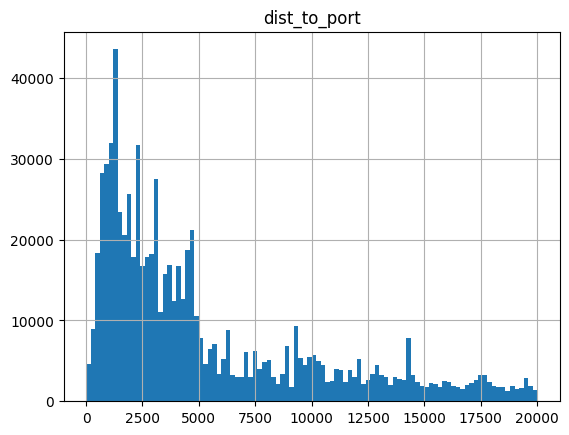

In [8]:
train_df_with_dist.query("dist_to_port < 20000").hist("dist_to_port", bins=100)

In [9]:
import contextily as cx
import numpy as np

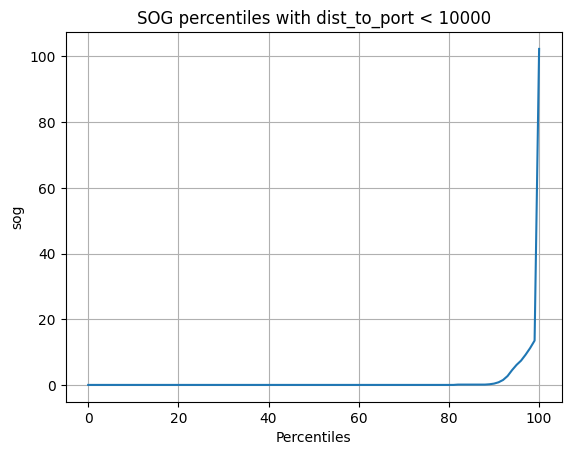

In [10]:
# Seems like dist_to_port < 10000 can be a good surrogate feature for "moored"
# But there are clearly some outliers (will look at this more closely in vessels notebook)
percentiles = np.arange(0.0, 1.01, step=0.01)
plt.plot(
    percentiles * 100,
    train_df_with_dist.query("dist_to_port < 10000")["sog"].quantile(percentiles),
)
plt.grid(True)
plt.xlabel("Percentiles")
plt.ylabel("sog")
plt.title("SOG percentiles with dist_to_port < 10000")
plt.show()

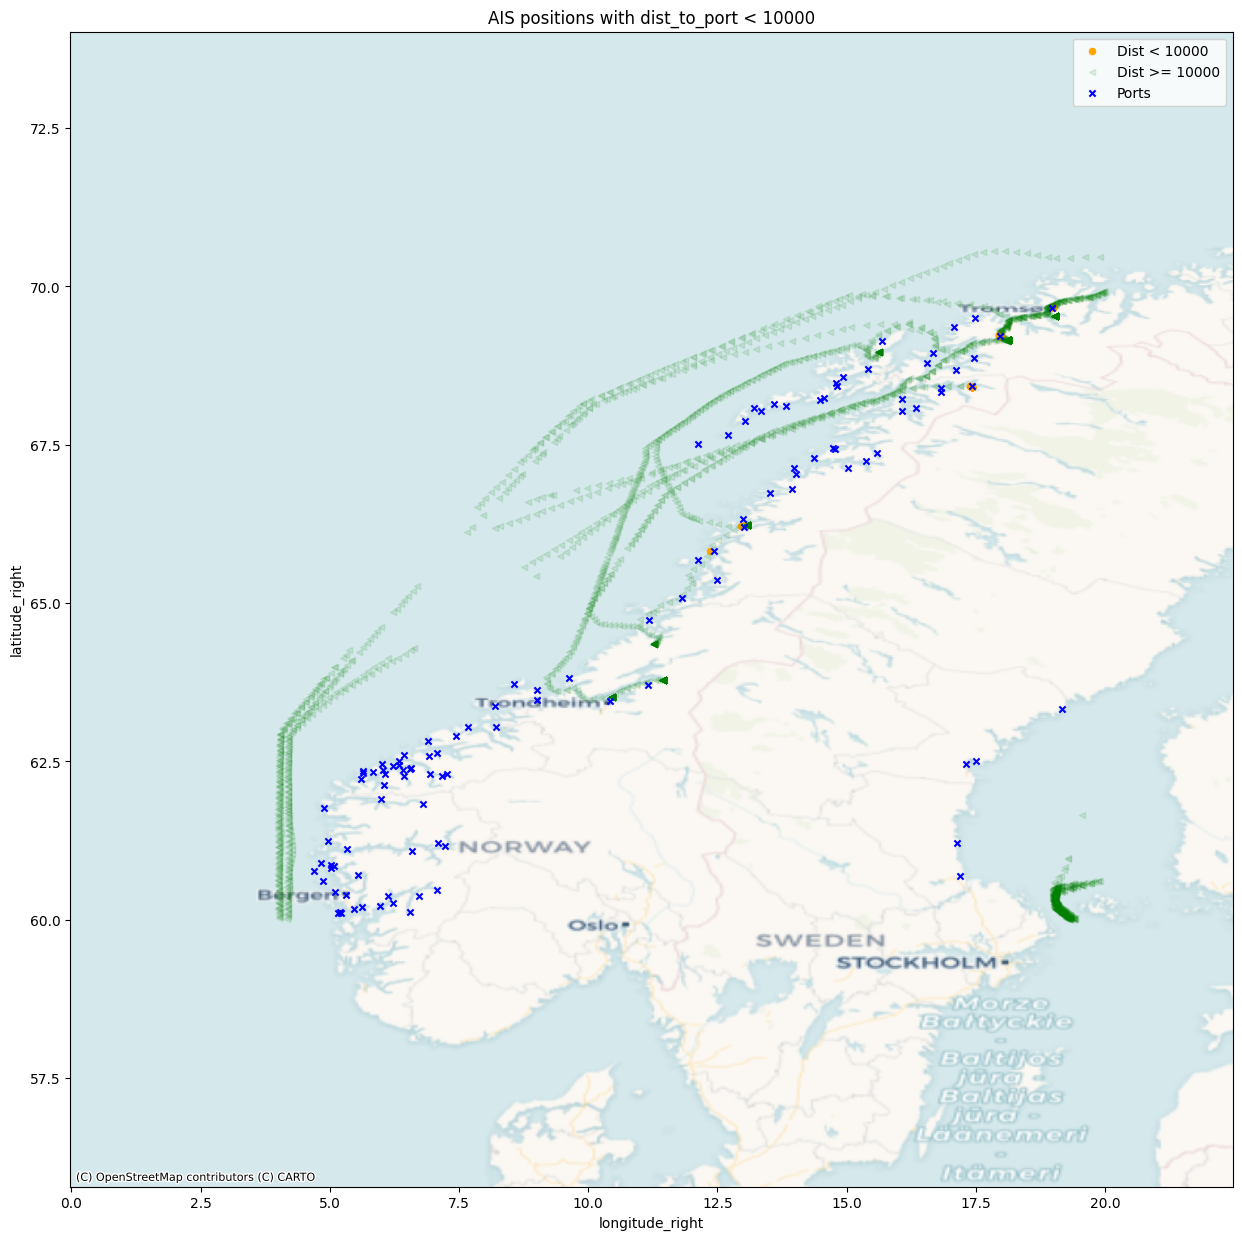

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
train_df_with_dist.query(
    "0 < longitude < 20 & latitude > 60 & dist_to_port < 10000"
).plot.scatter(
    "longitude", "latitude", c="orange", ax=ax, label="Dist < 10000", marker="o"
)
train_df_with_dist.query(
    "0 < longitude < 20 & latitude > 60 & dist_to_port >= 10000"
).plot.scatter(
    "longitude",
    "latitude",
    c="green",
    ax=ax,
    label="Dist >= 10000",
    alpha=0.1,
    marker="<",
)
cx.add_basemap(
    ax=ax,
    crs="EPSG:4326",
    zoom=5,
    source=cx.providers.CartoDB.Voyager,
    interpolation=None,
    reset_extent=False,
)
ports.query("0 < longitude_right < 20 & latitude_right > 60").plot.scatter(
    "longitude_right", "latitude_right", ax=ax, c="blue", marker="x", label="Ports"
)
plt.title("AIS positions with dist_to_port < 10000")
plt.legend()
plt.show()

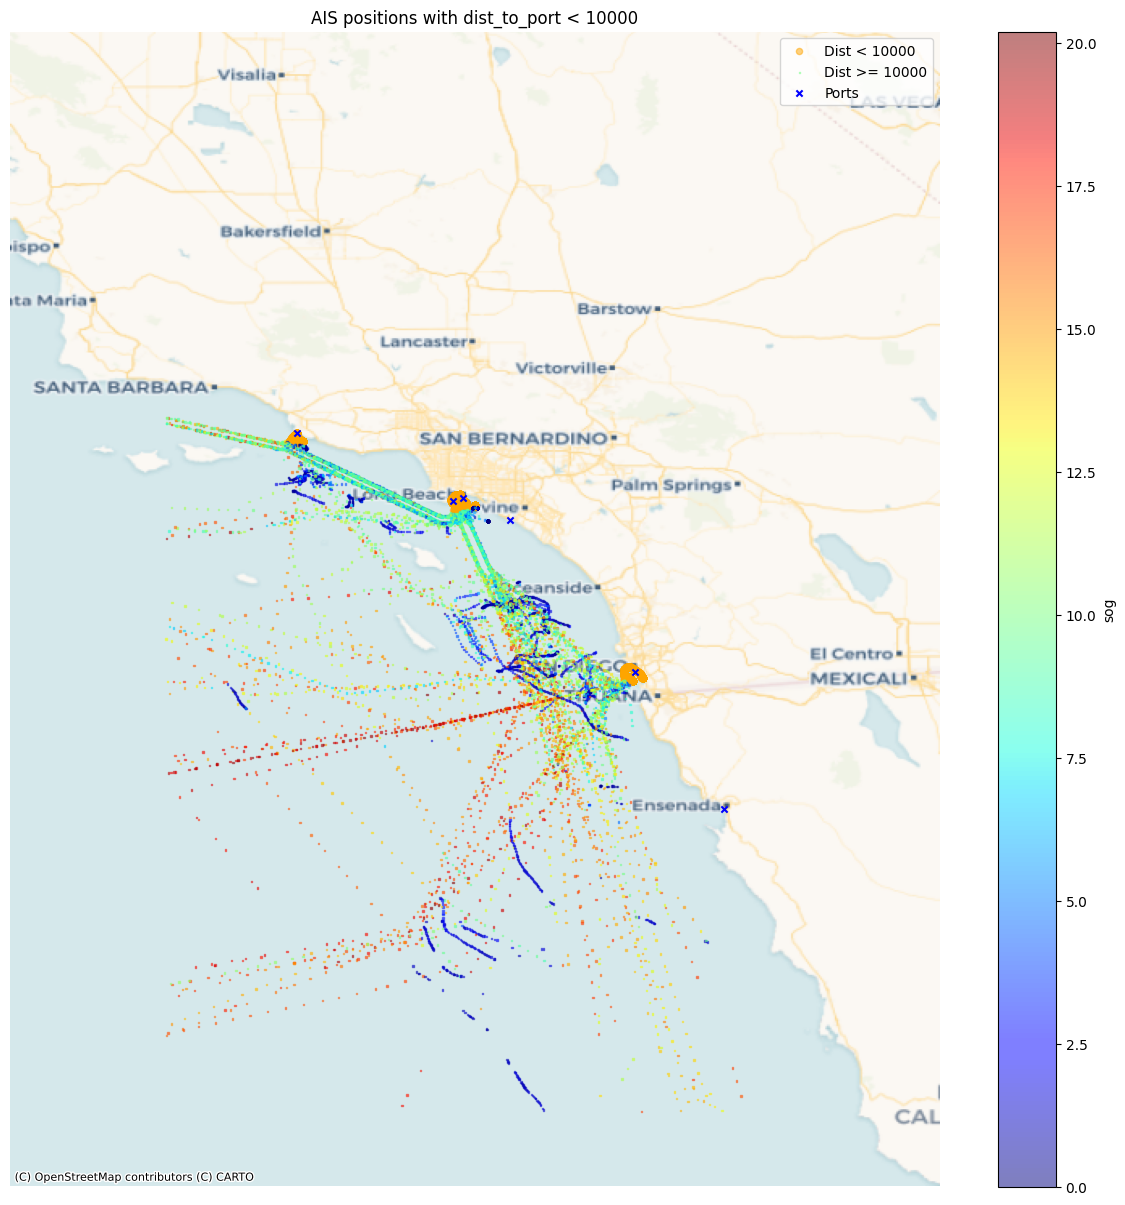

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
train_df_with_dist.query(
    "-120 < longitude < -110 & 30 < latitude < 40 & dist_to_port < 10000"
).plot.scatter(
    "longitude",
    "latitude",
    c="orange",
    ax=ax,
    label="Dist < 10000",
    marker="o",
    alpha=0.5,
)
train_df_with_dist.query(
    "-120 < longitude < -110 & 30 < latitude < 40 & dist_to_port >= 10000"
).plot.scatter(
    "longitude",
    "latitude",
    c="sog",
    cmap="jet",
    ax=ax,
    label="Dist >= 10000",
    marker=",",
    s=1,
    alpha=0.5,
)
cx.add_basemap(
    ax=ax,
    crs="EPSG:4326",
    zoom=7,
    source=cx.providers.CartoDB.Voyager,
    interpolation=None,
    reset_extent=False,
)
ports.query("-120 < longitude_right < -110 & 30 < latitude_right < 40").plot.scatter(
    "longitude_right", "latitude_right", ax=ax, c="blue", marker="x", label="Ports"
)
plt.title("AIS positions with dist_to_port < 10000")
plt.legend()
ax.set_axis_off()
plt.show()

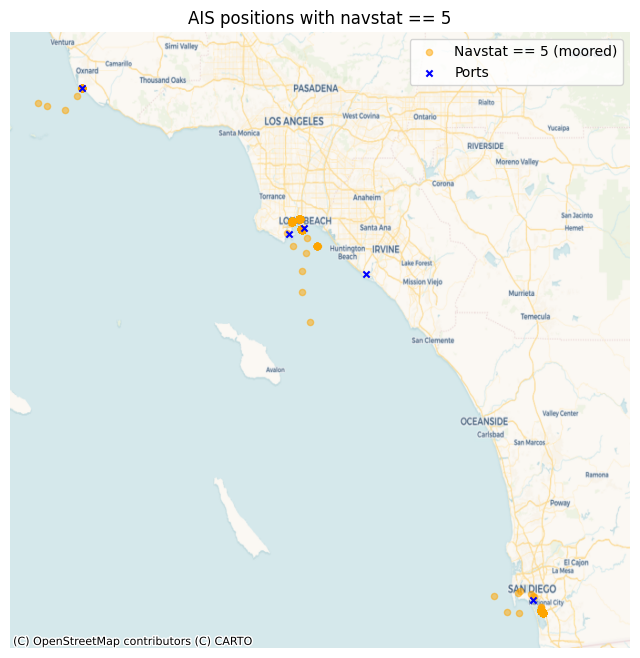

In [56]:
# By comparison, it seems like there is some mislabeling with navstat = 5
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
train_df_with_dist.query(
    "-120 < longitude < -110 & 30 < latitude < 40 & navstat == 5"
).plot.scatter(
    "longitude",
    "latitude",
    c="orange",
    ax=ax,
    label="Navstat == 5 (moored)",
    marker="o",
    alpha=0.5,
)
cx.add_basemap(
    ax=ax,
    crs="EPSG:4326",
    zoom=9,
    source=cx.providers.CartoDB.Voyager,
    interpolation=None,
    reset_extent=False,
)
ports.query("-120 < longitude_right < -110 & 30 < latitude_right < 40").plot.scatter(
    "longitude_right", "latitude_right", ax=ax, c="blue", marker="x", label="Ports"
)
plt.title("AIS positions with navstat == 5")
plt.legend()
ax.set_axis_off()
plt.show()